In [11]:
import os 

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(os.path.join(os.path.abspath(''), 'plot_style.mplstyle'))
plots_dir = '../plots/'

from pypower import BaseMatrix
from desilike.samples import Profiles, Chain, plotting
from emulator_fit import get_power_likelihood, get_corr_likelihood
from desilike.theories.galaxy_clustering import LPTVelocileptorsTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.profilers import MinuitProfiler

tracer = 'ELG'
region = 'SGC'
stat = 'power'
completeness = 'complete_'
theory = 'velocileptors'
rp_cut = 2.5
fc = ''

In [2]:
data_dir = '/global/cfs/cdirs/desi/users/mpinon/'

In [3]:
emulator_dir = '/global/cfs/cdirs/desi/users/mpinon/emulators/emulators_shapefit_{}'.format(tracer)
profiles_dir = '/global/cfs/cdirs/desi/users/mpinon/profiles/profiles_shapefit_{}_{{}}{}'.format(tracer, region)
chains_dir = '/global/cfs/cdirs/desi/users/mpinon/chains/chains_shapefit_{}_{{}}{}'.format(tracer, region)

In [4]:
#profiles = Profiles.load(os.path.join(profiles_dir.format('complete_'), '{}{}_velocileptors_marginalized.npy'.format(stat, '_xinmax0.35' if stat=='power' else '')))
profiles_rp_cut = Profiles.load(os.path.join(profiles_dir.format('complete_'), '{}{}_velocileptors{}_marginalized.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', '_th{:.1f}'.format(rp_cut))))
#profiles_complete = Profiles.load(os.path.join(profiles_dir.format('complete_'), '{}{}_velocileptors.npy'.format(stat, '_xinmax0.35' if stat=='power' else '')))
profiles_complete_rp_cut = Profiles.load(os.path.join(profiles_dir.format('complete_'), '{}{}_velocileptors{}{}{}.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', '_fc' if stat=='corr' else '', '_th{:.1f}'.format(rp_cut), '_directedges_max5000' if stat=='power' and rp_cut else '')))

In [5]:
#print(profiles.to_stats(tablefmt='latex'))

In [6]:
print(profiles_rp_cut.to_stats(tablefmt='latex'))

\begin{tabular}{llrr}
\hline
 chi2 / (108 - 13) = 3.00 / 95 = 0.03   & varied   &   bestfit &   error \\
\hline
 qpar                                   & True     &     0.979 &   0.014 \\
 qper                                   & True     &     1.005 &   0.01  \\
 dm                                     & True     &     0.002 &   0.027 \\
 df                                     & True     &     1.074 &   0.024 \\
 b1                                     & True     &     0.159 &   0.016 \\
 b2                                     & True     &     0.97  &   0.54  \\
 bs                                     & True     &     0.94  &   0.32  \\
 alpha0                                 & True     &    11.6   &   7.4   \\
 alpha2                                 & True     &   -21     &   6.3   \\
 alpha4                                 & True     &    12.8   &   4.4   \\
 sn0                                    & True     &    -0.031 &   0.046 \\
 sn2                                    & True     &

In [7]:
print(profiles_complete_rp_cut.to_stats(tablefmt='latex'))

\begin{tabular}{llrr}
\hline
 chi2 / (108 - 13) = 3.21 / 95 = 0.03   & varied   &   bestfit &   error \\
\hline
 qpar                                   & True     &    0.984  &  0.014  \\
 qper                                   & True     &    1.003  &  0.011  \\
 dm                                     & True     &    0.003  &  0.019  \\
 df                                     & True     &    1.07   &  0.03   \\
 b1                                     & True     &    0.144  &  0.018  \\
 b2                                     & True     &   -0.88   &  0.2    \\
 bs                                     & True     &    2.44   &  0.19   \\
 alpha0                                 & True     &   12.4    &  1.6    \\
 alpha2                                 & True     &   -3.4    &  2.5    \\
 alpha4                                 & True     &    3.5    &  2.5    \\
 sn0                                    & True     &    0.0017 &  0.0058 \\
 sn2                                    & True     &

In [8]:
#print(profiles_complete.to_stats(tablefmt='latex'))

In [12]:
emulator_fn = os.path.join(emulator_dir, 'power_xinmax0.35_{}.npy'.format(theory))
footprint_fn = os.path.join(emulator_dir, 'footprint_{}.npy')

data = np.load(os.path.join(data_dir, 'power_spectra/power_spectrum_25mocks_{}_{}{}{}{}.npy'.format(tracer, completeness, region, '_zcut' if completeness else '', '_th{:.1f}'.format(rp_cut) if rp_cut else '')))
#theory = LPTVelocileptorsTracerPowerSpectrumMultipoles.load(os.path.join(data_dir, 'theory_{}.npy'.format(tracer)))
from desilike.emulators import EmulatedCalculator
pt = EmulatedCalculator.load(emulator_fn)
theory = LPTVelocileptorsTracerPowerSpectrumMultipoles(pt=pt)
wmatrix = BaseMatrix.load(os.path.join(data_dir, 'windows/wm_mock0_{}_{}{}{}_rebinned.npy'.format(tracer, completeness, region, '_rp{:.1f}'.format(rp_cut) if rp_cut else '')))
cov = np.load(os.path.join(data_dir, 'cov_{}_{}{}{}.npy'.format(tracer, completeness, region, '_rp{:.1f}'.format(rp_cut) if rp_cut else '')))
shotnoise = np.load(os.path.join(data_dir, 'shotnoise_pk_25mocks_{}_{}{}{}.npy'.format(tracer, completeness, region, '_th{:.1f}'.format(rp_cut) if rp_cut else '')))

print('likelihood')
from marginalized_likelihood import get_power_marg_likelihood
likelihood = get_power_marg_likelihood(data, theory, wmatrix, cov, shotnoise=shotnoise, ells=[0, 2, 4], idces=[-1], solve=False)

likelihood
hello


PipelineError: Error in method initialize of <desilike.theories.galaxy_clustering.full_shape.LPTVelocileptorsTracerPowerSpectrumMultipoles object at 0x7f99fc7715a0>

NameError: name 'profiles' is not defined

<Figure size 1000x1000 with 0 Axes>

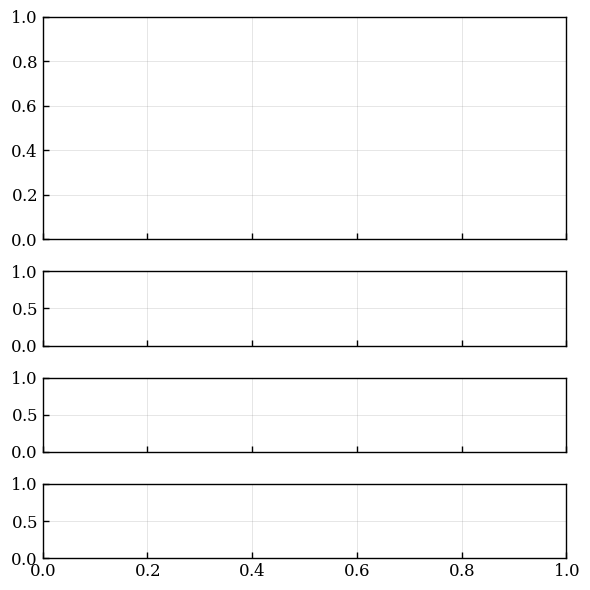

In [6]:
likelihood.solved_default = '.best'
obs = likelihood.observables[0]

height_ratios = [max(len(obs.ells), 3)] + [1] * len(obs.ells)
figsize = (6, 1. * sum(height_ratios))
fig, lax = plt.subplots(len(height_ratios), sharex=True, sharey=False, gridspec_kw={'height_ratios': height_ratios}, figsize=figsize, squeeze=True)
fig.subplots_adjust(hspace=0)
data, std = obs.data, obs.std

print(profiles.bestfit.choice(input=True), likelihood.varied_params)
likelihood(**profiles.bestfit.choice(input=True))
models = [obs.theory]

scaling = 'kpk'
k_exp = 1 if scaling == 'kpk' else 0
for ill, ell in enumerate(obs.ells):
    lax[0].errorbar(obs.k[ill], obs.k[ill]**k_exp * data[ill], yerr=obs.k[ill]**k_exp * std[ill], color='C{:d}'.format(ill), linestyle='none', marker='o', label=r'$\ell = {:d}$'.format(ell))
    for i, m in enumerate(models):
        lax[0].plot(obs.k[ill], obs.k[ill]**k_exp * m[ill], color='C{:d}'.format(ill))
for ill, ell in enumerate(obs.ells):
    for i, m in enumerate(models):
        lax[ill + 1].plot(obs.k[ill], (data[ill] - m[ill]) / std[ill], color='C{:d}'.format(ill))
    lax[ill + 1].set_ylim(-4, 4)
    for offset in [-2., 2.]: lax[ill + 1].axhline(offset, color='k', linestyle='--')
    lax[ill + 1].set_ylabel(r'$\Delta P_{{{0:d}}} / \sigma_{{ P_{{{0:d}}} }}$'.format(ell))
for ax in lax: ax.grid(True)
lax[0].legend()
if scaling == 'kpk':
    lax[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
if scaling == 'loglog':
    lax[0].set_ylabel(r'$P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
    lax[0].set_yscale('log')
    lax[0].set_xscale('log')
lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
fig = plt.gcf()
fig.align_ylabels()
plt.show()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/tmp/ipykernel_1487991/2665178148.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(plots_dir, 'corner_plot_{}_complete_{}_{}_th{:.1f}_marginalized_astar.png'.format(tracer, region, stat, rp_cut)), dpi=300)


<Figure size 1000x1000 with 0 Axes>

/global/cfs/cdirs/desi/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


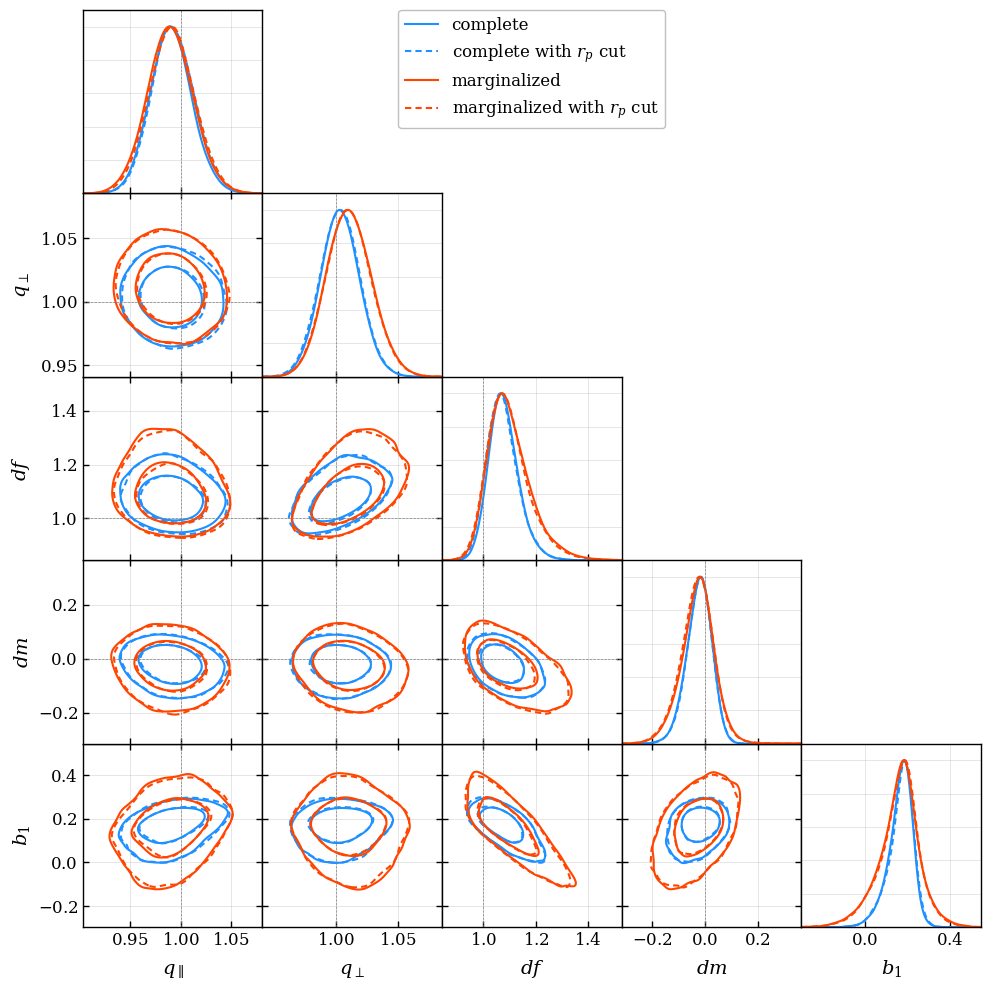

In [16]:
from getdist import plots
g = plots.get_single_plotter(width_inch=10, scaling=False, ratio=1)
g.settings.axes_fontsize = 12

chain_complete = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), 'power_xinmax0.35_velocileptors_{:d}.npy'.format(i))).remove_burnin(0.5)[::10] for i in range(8)])
chain_complete_rp_cut = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), 'power_xinmax0.35_velocileptors_th{:.1f}_directedges_max5000_{:d}.npy'.format(rp_cut, i))).remove_burnin(0.5)[::10] for i in range(8)])
chain = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), 'power_xinmax0.35_velocileptors_{:d}_marginalized_astar_rpcutwmatrix.npy'.format(i))).remove_burnin(0.5)[::10] for i in range(8)])
chain_rp_cut = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), 'power_xinmax0.35_velocileptors_th{:.1f}_{:d}_marginalized_astar.npy'.format(rp_cut, i))).remove_burnin(0.5)[::10] for i in range(8)])

markers = {'qpar': 1., 'qper': 1., 'df': 1., 'dm': 0.}
colors = ['dodgerblue', 'dodgerblue', 'orangered', 'orangered']
plotting.plot_triangle([chain_complete, chain_complete_rp_cut, chain, chain_rp_cut], 
                       labels=['complete', r'complete with $r_p$ cut', r'marginalized', r'marginalized with $r_p$ cut'], 
                       params=['qpar', 'qper', 'df', 'dm', 'b1'], markers=markers,
                       g=g, lws=1.5, contour_lws=1.5, filled=False, colors=colors, contour_colors=colors, contour_ls=['-', '--', '-', '--'],
                       show=False)
fig = plt.gcf()
fig.align_ylabels()
plt.savefig(os.path.join(plots_dir, 'corner_plot_{}_complete_{}_{}_th{:.1f}_marginalized_astar.png'.format(tracer, region, stat, rp_cut)), dpi=300)
plt.show()

In [17]:
idx = [-3, -5, -7, -9, -11, -13]
chains = [Chain.load(os.path.join(chains_dir.format('complete_'), 'power_importance_xinmax0.35_velocileptors_th2.5_marginalized_astar_rpcutwmatrix_imarg{}.npy'.format(imarg))) for imarg in idx]
     

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/global/cfs/cdirs/desi/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


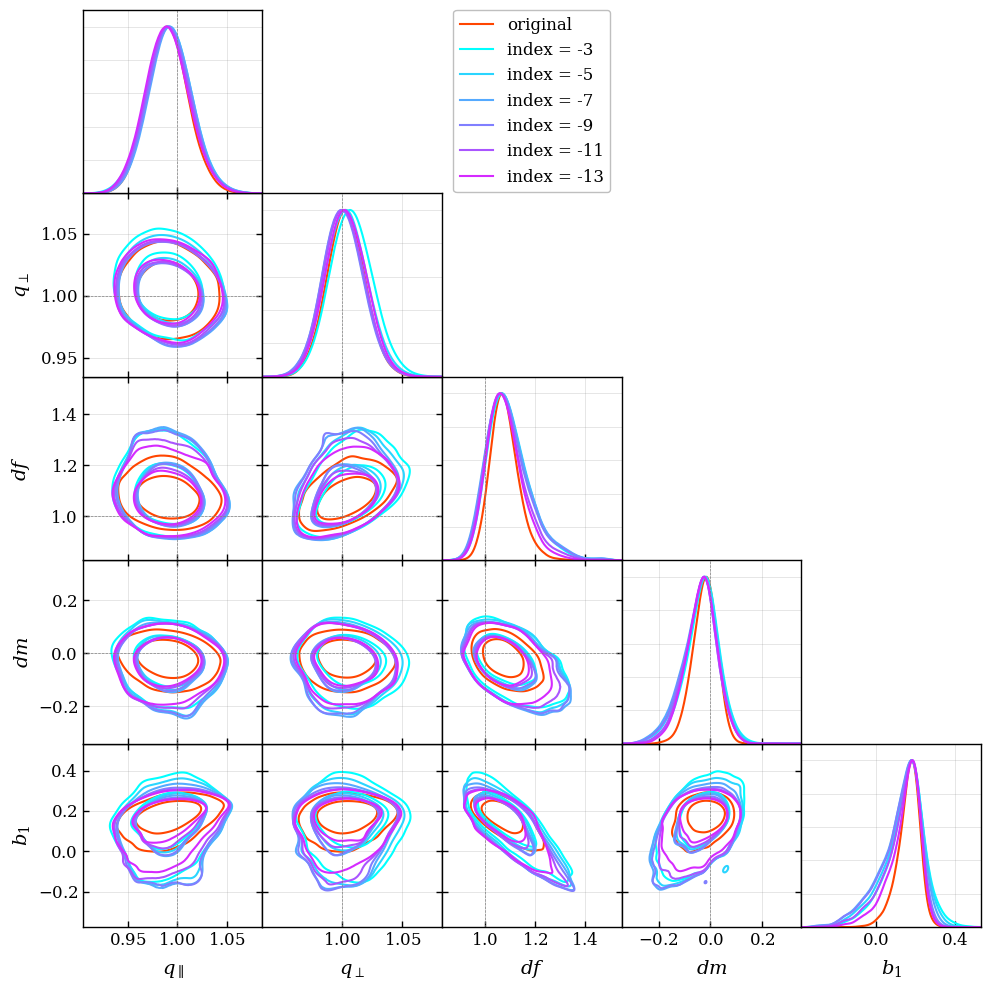

In [40]:
import matplotlib as mpl
cmap = mpl.colormaps['cool']

plotting.plot_triangle([chain_complete] + chains, 
                       labels=['original'] + ['index = {}'.format(i) for i in idx], 
                       params=['qpar', 'qper', 'df', 'dm', 'b1'], markers=markers,
                       g=g, lws=1.5, contour_lws=1.5, contour_colors=['orangered'] + [cmap(i/len(idx)) for i in range(len(idx))],
                       show=False)
fig = plt.gcf()
fig.align_ylabels()
plt.show()